<a href="https://colab.research.google.com/github/pratx08/Gen-AI/blob/main/Assignment%20-%201/Gen_AI_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Load Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Flatten images for logistic regression (28x28 -> 784)
X_train_flat = X_train.reshape(-1, 28*28) / 255.0
X_test_flat = X_test.reshape(-1, 28*28) / 255.0

# For GAN, we normalize to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_gan = scaler.fit_transform(X_train_flat)

Train shape: (60000, 28, 28) Test shape: (10000, 28, 28)


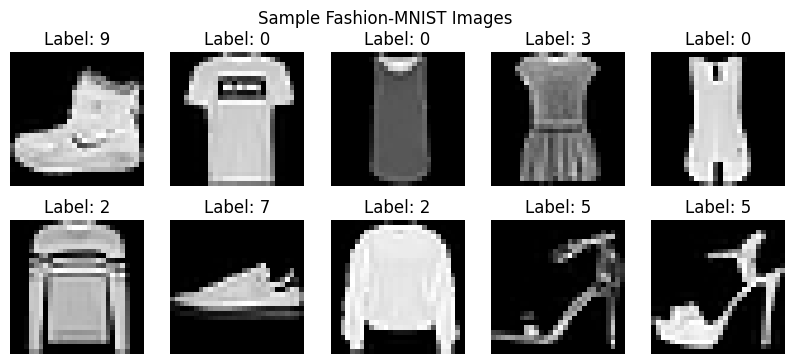

In [7]:
# Plot first 10 samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")
plt.suptitle("Sample Fashion-MNIST Images")
plt.show()

Logistic Regression Accuracy: 0.8432

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.72      0.74      0.73      1000
           3       0.83      0.86      0.84      1000
           4       0.74      0.76      0.75      1000
           5       0.95      0.92      0.93      1000
           6       0.62      0.57      0.59      1000
           7       0.91      0.94      0.93      1000
           8       0.93      0.94      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



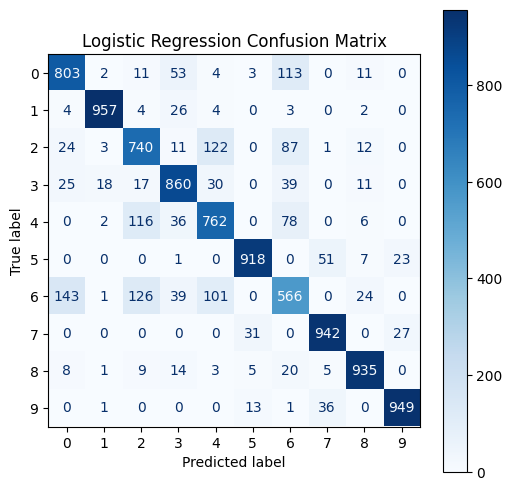

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Flatten and normalize for Logistic Regression
X_train_flat = X_train.reshape(-1, 28*28) / 255.0
X_test_flat = X_test.reshape(-1, 28*28) / 255.0

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_flat, y_train)

# Predictions
y_pred = lr_model.predict(X_test_flat)

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Step 200/1000 | Loss D: 0.9964 | Loss G: 0.8036
Step 400/1000 | Loss D: 0.6481 | Loss G: 1.2252
Step 600/1000 | Loss D: 0.5020 | Loss G: 1.4812
Step 800/1000 | Loss D: 0.5643 | Loss G: 1.3038
Step 1000/1000 | Loss D: 0.5628 | Loss G: 1.3549


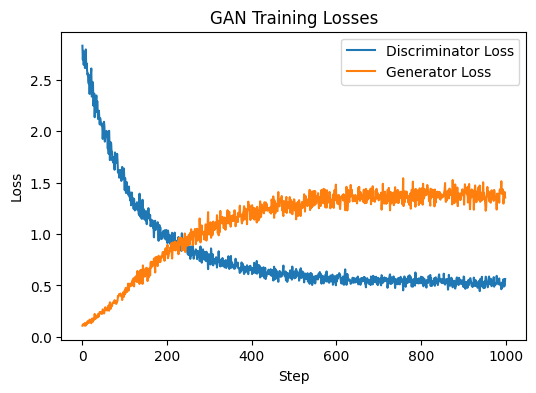

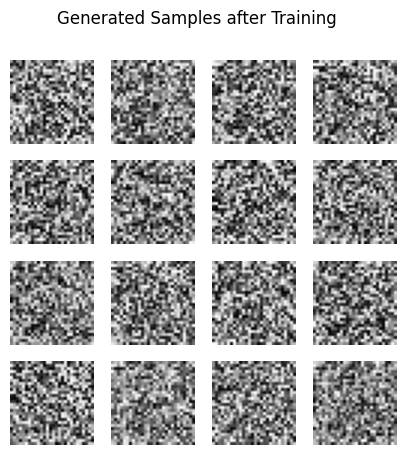

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Preprocess data for GAN
X_train_flat = X_train.reshape(-1, 28*28)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_gan = scaler.fit_transform(X_train_flat)

# Hyperparameters
noise_dim = 100
hidden_dim = 128
batch_size = 128
num_steps = 1000
lr = 0.0002

rng = np.random.default_rng(seed=42)

def init_weights(shape):
    return rng.normal(0, 0.1, size=shape)

# Initialize weights
# Generator
W1_g = init_weights((noise_dim, hidden_dim))
b1_g = np.zeros(hidden_dim)
W2_g = init_weights((hidden_dim, 28*28))
b2_g = np.zeros(28*28)

# Discriminator
W1_d = init_weights((28*28, hidden_dim))
b1_d = np.zeros(hidden_dim)
W2_d = init_weights((hidden_dim, 1))
b2_d = np.zeros(1)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Training loop
losses_d, losses_g = [], []

for step in range(num_steps):
    # Real batch
    idx = rng.choice(len(X_train_gan), size=batch_size, replace=False)
    real_batch = X_train_gan[idx]

    # Fake batch
    z = rng.normal(0, 1, size=(batch_size, noise_dim))
    g_h_pre = z @ W1_g + b1_g
    g_h = np.maximum(0, g_h_pre)
    g_pre = g_h @ W2_g + b2_g
    fake_batch = np.tanh(g_pre)

    # Discriminator
    d_h_pre_real = real_batch @ W1_d + b1_d
    d_h_real = np.maximum(0, d_h_pre_real)
    d_logits_real = d_h_real @ W2_d + b2_d
    d_out_real = sigmoid(d_logits_real)

    d_h_pre_fake = fake_batch @ W1_d + b1_d
    d_h_fake = np.maximum(0, d_h_pre_fake)
    d_logits_fake = d_h_fake @ W2_d + b2_d
    d_out_fake = sigmoid(d_logits_fake)

    # Losses
    loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))
    loss_g = -np.mean(np.log(d_out_fake + 1e-8))
    losses_d.append(loss_d)
    losses_g.append(loss_g)

    # Backprop for Discriminator
    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    d_delta_real = (d_out_real - y_real) / batch_size
    d_delta_fake = (d_out_fake - y_fake) / batch_size
    grad_W2_d = d_h_real.T @ d_delta_real + d_h_fake.T @ d_delta_fake
    grad_b2_d = np.sum(d_delta_real + d_delta_fake, axis=0)
    d_grad_h_real = d_delta_real @ W2_d.T
    d_grad_h_real[d_h_pre_real <= 0] = 0
    d_grad_h_fake = d_delta_fake @ W2_d.T
    d_grad_h_fake[d_h_pre_fake <= 0] = 0
    grad_W1_d = real_batch.T @ d_grad_h_real + fake_batch.T @ d_grad_h_fake
    grad_b1_d = np.sum(d_grad_h_real + d_grad_h_fake, axis=0)

    # Update Discriminator
    W2_d -= lr * grad_W2_d
    b2_d -= lr * grad_b2_d
    W1_d -= lr * grad_W1_d
    b1_d -= lr * grad_b1_d

    # Backprop for Generator
    y_gen = np.ones((batch_size, 1))
    g_delta_d = (d_out_fake - y_gen) / batch_size
    g_grad_h_fake = g_delta_d @ W2_d.T
    g_grad_h_fake[d_h_pre_fake <= 0] = 0
    grad_fake_input = g_grad_h_fake @ W1_d.T
    grad_g_pre = grad_fake_input * (1 - fake_batch**2)
    grad_W2_g = g_h.T @ grad_g_pre
    grad_b2_g = np.sum(grad_g_pre, axis=0)
    g_grad_h = grad_g_pre @ W2_g.T
    g_grad_h[g_h_pre <= 0] = 0
    grad_W1_g = z.T @ g_grad_h
    grad_b1_g = np.sum(g_grad_h, axis=0)

    # Update Generator
    W2_g -= lr * grad_W2_g
    b2_g -= lr * grad_b2_g
    W1_g -= lr * grad_W1_g
    b1_g -= lr * grad_b1_g

    if (step+1) % 200 == 0:
        print(f"Step {step+1}/{num_steps} | Loss D: {loss_d:.4f} | Loss G: {loss_g:.4f}")

# Plot Loss Curves
plt.figure(figsize=(6,4))
plt.plot(losses_d, label="Discriminator Loss")
plt.plot(losses_g, label="Generator Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.show()

# Generate and Visualize Samples
z_sample = rng.normal(0, 1, size=(16, noise_dim))
g_h_pre = z_sample @ W1_g + b1_g
g_h = np.maximum(0, g_h_pre)
g_pre = g_h @ W2_g + b2_g
fake_samples = np.tanh(g_pre)

fig, axes = plt.subplots(4, 4, figsize=(5,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_samples[i].reshape(28,28), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated Samples after Training")
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Load and preprocess dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train_flat = X_train.reshape(-1, 28*28) / 255.0
X_test_flat = X_test.reshape(-1, 28*28) / 255.0

print("Train shape:", X_train_flat.shape, "Test shape:", X_test_flat.shape)

Train shape: (60000, 784) Test shape: (10000, 784)


In [11]:
# Use smaller subset for faster training
subset_size = 20000
X_train_sub, y_train_sub = X_train_flat[:subset_size], y_train[:subset_size]
X_test_sub, y_test_sub = X_test_flat[:2000], y_test[:2000]

# SVM (RBF kernel)
svm_clf = SVC(kernel="rbf", gamma="scale")
svm_clf.fit(X_train_sub, y_train_sub)
print("SVM accuracy:", accuracy_score(y_test_sub, svm_clf.predict(X_test_sub)))

# Decision Tree
tree_clf = DecisionTreeClassifier(max_depth=20)
tree_clf.fit(X_train_sub, y_train_sub)
print("Decision Tree accuracy:", accuracy_score(y_test_sub, tree_clf.predict(X_test_sub)))

SVM accuracy: 0.8745
Decision Tree accuracy: 0.763


LogReg L2 Accuracy (5k): 0.822
LogReg L1 Accuracy (5k): 0.82


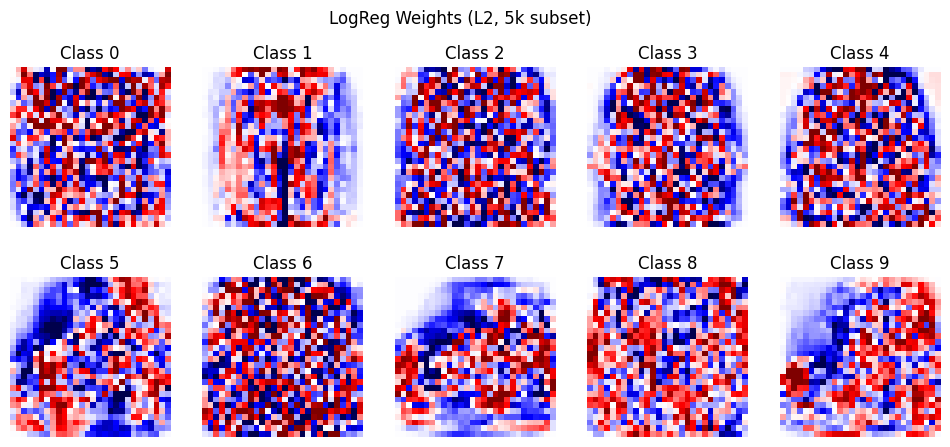

In [12]:
import warnings
warnings.filterwarnings("ignore")
# Logistic Regression on 5k subset
subset_size = 5000
X_sub, y_sub = X_train_flat[:subset_size], y_train[:subset_size]
X_test_sub, y_test_sub = X_test_flat[:1000], y_test[:1000]

# L2 regularization
lr_l2 = LogisticRegression(penalty="l2", max_iter=1000, solver="lbfgs")
lr_l2.fit(X_sub, y_sub)
print("LogReg L2 Accuracy (5k):", accuracy_score(y_test_sub, lr_l2.predict(X_test_sub)))

# L1 regularization
lr_l1 = LogisticRegression(penalty="l1", solver="saga", max_iter=1000)
lr_l1.fit(X_sub, y_sub)
print("LogReg L1 Accuracy (5k):", accuracy_score(y_test_sub, lr_l1.predict(X_test_sub)))

# Heatmaps for L2 weights
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(lr_l2.coef_[i].reshape(28, 28), cmap="seismic", vmin=-0.5, vmax=0.5)
    ax.set_title(f"Class {i}")
    ax.axis("off")
plt.suptitle("LogReg Weights (L2, 5k subset)")
plt.show()


In [13]:
# Cross-validation on 10k subset
from sklearn.model_selection import cross_val_score

subset_size = 10000
X_cv, y_cv = X_train_flat[:subset_size], y_train[:subset_size]

lr_cv = LogisticRegression(max_iter=300, solver="lbfgs")
scores = cross_val_score(lr_cv, X_cv, y_cv, cv=5)

print("Cross-val mean accuracy:", np.mean(scores))
print("Cross-val std dev     :", np.std(scores))

Cross-val mean accuracy: 0.8291000000000001
Cross-val std dev     : 0.009361623790774784


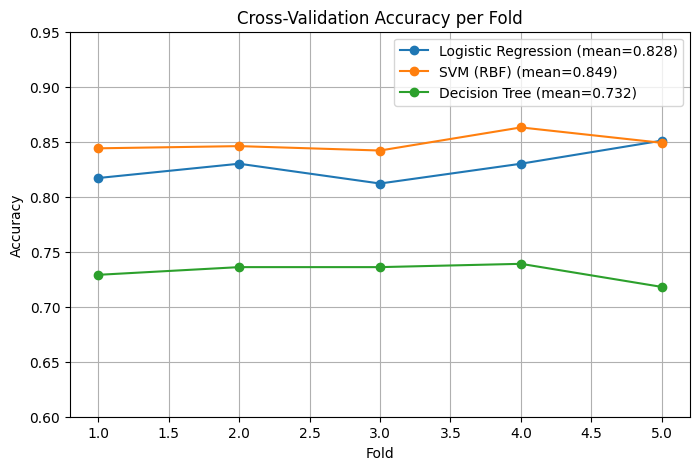

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

# Smaller subset for speed
subset_size = 5000
X_sub, y_sub = X_train_flat[:subset_size], y_train[:subset_size]

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "SVM (RBF)": SVC(kernel="rbf", gamma="scale"),
    "Decision Tree": DecisionTreeClassifier(max_depth=20)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(8,5))

for name, model in models.items():
    scores = cross_val_score(model, X_sub, y_sub, cv=cv)
    plt.plot(range(1, len(scores)+1), scores, marker="o", label=f"{name} (mean={scores.mean():.3f})")

plt.title("Cross-Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0.6, 0.95)
plt.legend()
plt.grid(True)
plt.show()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Step 500/5000 | Loss D: 0.4846 | Loss G: 1.6724
Step 1000/5000 | Loss D: 0.3688 | Loss G: 1.7630
Step 1500/5000 | Loss D: 0.4035 | Loss G: 1.7661
Step 2000/5000 | Loss D: 0.4349 | Loss G: 1.7131
Step 2500/5000 | Loss D: 0.4569 | Loss G: 1.7012
Step 3000/5000 | Loss D: 0.4434 | Loss G: 1.6277
Step 3500/5000 | Loss D: 0.4999 | Loss G: 1.5813
Step 4000/5000 | Loss D: 0.4956 | Loss G: 1.5642
Step 4500/5000 | Loss D: 0.4996 | Loss G: 1.7075
Step 5000/5000 | Loss D: 0.4458 | Loss G: 1.7048


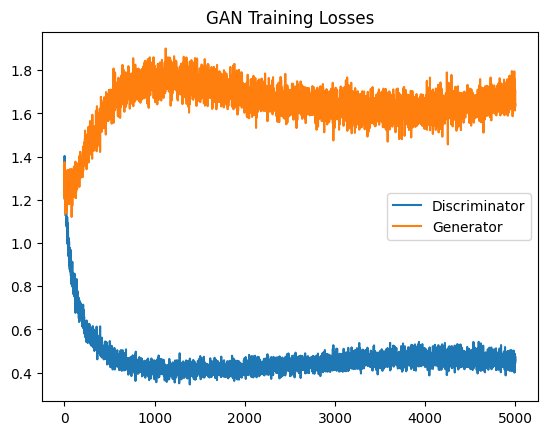

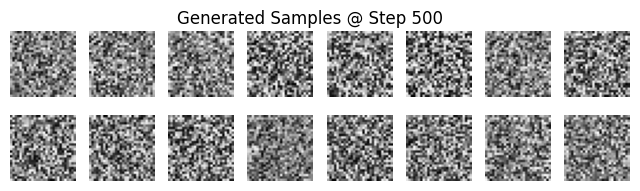

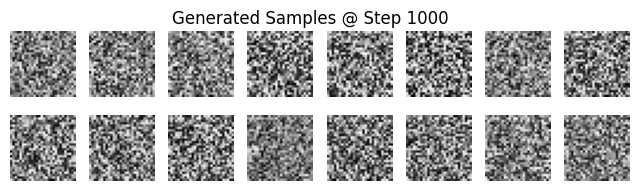

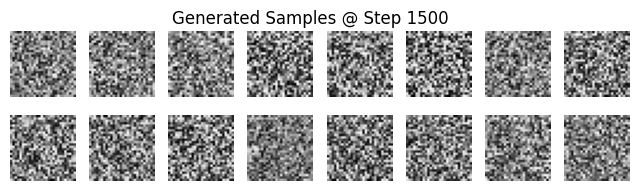

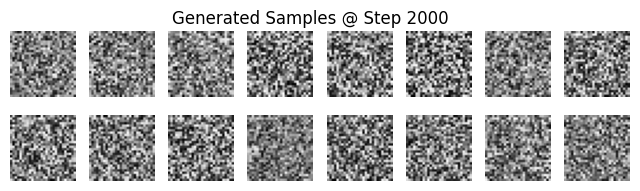

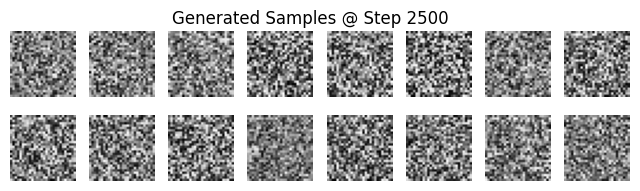

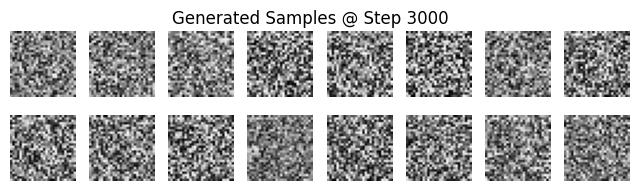

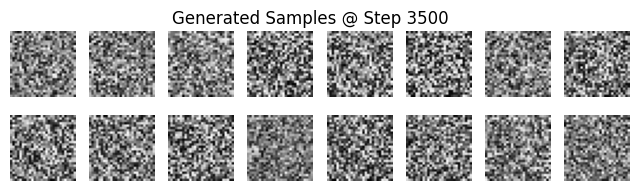

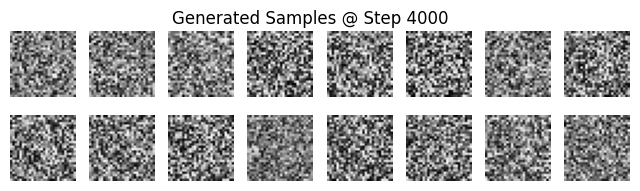

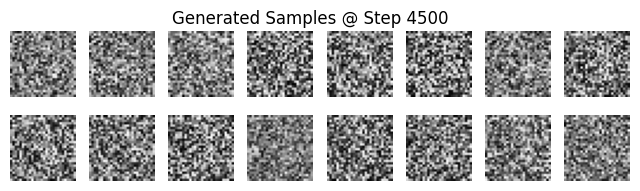

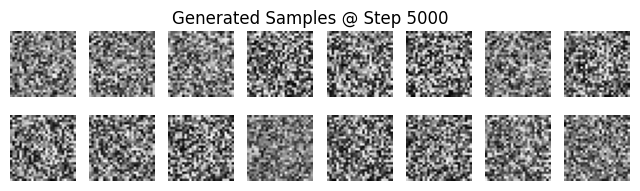

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import fashion_mnist

# Data prep
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train_flat = X_train.reshape(-1, 28*28)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_gan = scaler.fit_transform(X_train_flat)

# Hyperparameters
noise_dim = 100
hidden_dim = 128
batch_size = 128
num_steps = 5000
lr_d, lr_g = 0.0002, 0.0001  # different LR for D and G

rng = np.random.default_rng(seed=42)
def init_weights(shape): return rng.normal(0, 0.1, size=shape)
def sigmoid(x): return 1 / (1 + np.exp(-x))
def leaky_relu(x, alpha=0.2): return np.where(x > 0, x, alpha * x)

# Generator params (2 hidden layers)
W1_g, b1_g = init_weights((noise_dim, hidden_dim)), np.zeros(hidden_dim)
W2_g, b2_g = init_weights((hidden_dim, hidden_dim)), np.zeros(hidden_dim)
W3_g, b3_g = init_weights((hidden_dim, 28*28)), np.zeros(28*28)

# Discriminator params (2 hidden layers)
W1_d, b1_d = init_weights((28*28, hidden_dim)), np.zeros(hidden_dim)
W2_d, b2_d = init_weights((hidden_dim, hidden_dim)), np.zeros(hidden_dim)
W3_d, b3_d = init_weights((hidden_dim, 1)), np.zeros(1)

# Training loop
losses_d, losses_g, snapshots = [], [], {}
fixed_z = rng.normal(0, 1, size=(16, noise_dim))

for step in range(num_steps):
    # Real batch
    idx = rng.choice(len(X_train_gan), size=batch_size, replace=False)
    real_batch = X_train_gan[idx]

    # Fake batch (forward pass Generator)
    z = rng.normal(0, 1, size=(batch_size, noise_dim))
    g_h1 = leaky_relu(z @ W1_g + b1_g)
    g_h2 = leaky_relu(g_h1 @ W2_g + b2_g)
    fake_batch = np.tanh(g_h2 @ W3_g + b3_g)

    # Discriminator forward pass
    d_h1_real = leaky_relu(real_batch @ W1_d + b1_d)
    d_h2_real = leaky_relu(d_h1_real @ W2_d + b2_d)
    d_out_real = sigmoid(d_h2_real @ W3_d + b3_d)

    d_h1_fake = leaky_relu(fake_batch @ W1_d + b1_d)
    d_h2_fake = leaky_relu(d_h1_fake @ W2_d + b2_d)
    d_out_fake = sigmoid(d_h2_fake @ W3_d + b3_d)

    # Losses
    # Label smoothing: real labels ∈ [0.8,1.0]
    y_real = rng.uniform(0.8, 1.0, size=(batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))
    loss_g = -np.mean(np.log(d_out_fake + 1e-8))
    losses_d.append(loss_d); losses_g.append(loss_g)

    # Backprop Discriminator
    d_delta_real = (d_out_real - y_real) / batch_size
    d_delta_fake = (d_out_fake - y_fake) / batch_size

    grad_W3_d = d_h2_real.T @ d_delta_real + d_h2_fake.T @ d_delta_fake
    grad_b3_d = np.sum(d_delta_real + d_delta_fake, axis=0)

    d_grad_h2_real = (d_delta_real @ W3_d.T); d_grad_h2_real[d_h2_real <= 0] *= 0.2
    d_grad_h2_fake = (d_delta_fake @ W3_d.T); d_grad_h2_fake[d_h2_fake <= 0] *= 0.2
    grad_W2_d = d_h1_real.T @ d_grad_h2_real + d_h1_fake.T @ d_grad_h2_fake
    grad_b2_d = np.sum(d_grad_h2_real + d_grad_h2_fake, axis=0)

    d_grad_h1_real = (d_grad_h2_real @ W2_d.T); d_grad_h1_real[d_h1_real <= 0] *= 0.2
    d_grad_h1_fake = (d_grad_h2_fake @ W2_d.T); d_grad_h1_fake[d_h1_fake <= 0] *= 0.2
    grad_W1_d = real_batch.T @ d_grad_h1_real + fake_batch.T @ d_grad_h1_fake
    grad_b1_d = np.sum(d_grad_h1_real + d_grad_h1_fake, axis=0)

    W3_d -= lr_d * grad_W3_d; b3_d -= lr_d * grad_b3_d
    W2_d -= lr_d * grad_W2_d; b2_d -= lr_d * grad_b2_d
    W1_d -= lr_d * grad_W1_d; b1_d -= lr_d * grad_b1_d

    # Backprop Generator
    g_delta_d = (d_out_fake - 1) / batch_size
    g_grad_h2_fake = (g_delta_d @ W3_d.T); g_grad_h2_fake[d_h2_fake <= 0] *= 0.2
    g_grad_h1_fake = (g_grad_h2_fake @ W2_d.T); g_grad_h1_fake[d_h1_fake <= 0] *= 0.2
    grad_fake_input = g_grad_h1_fake @ W1_d.T
    grad_g_pre = grad_fake_input * (1 - fake_batch**2)

    grad_W3_g = g_h2.T @ grad_g_pre; grad_b3_g = np.sum(grad_g_pre, axis=0)
    g_grad_h2 = grad_g_pre @ W3_g.T; g_grad_h2[g_h2 <= 0] *= 0.2
    grad_W2_g = g_h1.T @ g_grad_h2; grad_b2_g = np.sum(g_grad_h2, axis=0)
    g_grad_h1 = g_grad_h2 @ W2_g.T; g_grad_h1[g_h1 <= 0] *= 0.2
    grad_W1_g = z.T @ g_grad_h1; grad_b1_g = np.sum(g_grad_h1, axis=0)

    W3_g -= lr_g * grad_W3_g; b3_g -= lr_g * grad_b3_g
    W2_g -= lr_g * grad_W2_g; b2_g -= lr_g * grad_b2_g
    W1_g -= lr_g * grad_W1_g; b1_g -= lr_g * grad_b1_g

    # Save progress every 500 steps
    if (step+1) % 500 == 0:
        g_h1 = leaky_relu(fixed_z @ W1_g + b1_g)
        g_h2 = leaky_relu(g_h1 @ W2_g + b2_g)
        fake_samples = np.tanh(g_h2 @ W3_g + b3_g)
        snapshots[step+1] = fake_samples
        print(f"Step {step+1}/{num_steps} | Loss D: {loss_d:.4f} | Loss G: {loss_g:.4f}")

# Plot Loss Curves
plt.plot(losses_d, label="Discriminator")
plt.plot(losses_g, label="Generator")
plt.legend(); plt.title("GAN Training Losses"); plt.show()

# Show Generator Progress
for step, samples in snapshots.items():
    fig, axes = plt.subplots(2, 8, figsize=(8,2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28,28), cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Generated Samples @ Step {step}")
    plt.show()



=== Mode Collapse Experiment ===
Step 200/1000 | Loss D: 0.4789 | Loss G: 1.7247
Step 400/1000 | Loss D: 0.4359 | Loss G: 1.6837
Step 600/1000 | Loss D: 0.4503 | Loss G: 1.6558
Step 800/1000 | Loss D: 0.4126 | Loss G: 1.6177
Step 1000/1000 | Loss D: 0.4118 | Loss G: 1.7113


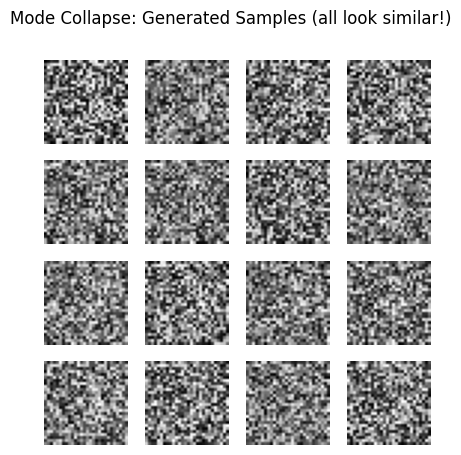

In [4]:
# --- Mode Collapse Experiment ---
print("\n=== Mode Collapse Experiment ===")

# Hyperparameters chosen to destabilize training
collapse_lr_d, collapse_lr_g = 0.01, 0.01   # too high
collapse_batch_size = 32
collapse_steps = 1000

losses_d_collapse, losses_g_collapse = [], []

for step in range(collapse_steps):
    idx = rng.choice(len(X_train_gan), size=collapse_batch_size, replace=False)
    real_batch = X_train_gan[idx]

    # Noise
    z = rng.normal(0, 1, size=(collapse_batch_size, noise_dim))
    g_h1 = leaky_relu(z @ W1_g + b1_g)
    g_h2 = leaky_relu(g_h1 @ W2_g + b2_g)
    fake_batch = np.tanh(g_h2 @ W3_g + b3_g)

    # Discriminator outputs
    d_h1_real = leaky_relu(real_batch @ W1_d + b1_d)
    d_h2_real = leaky_relu(d_h1_real @ W2_d + b2_d)
    d_out_real = sigmoid(d_h2_real @ W3_d + b3_d)

    d_h1_fake = leaky_relu(fake_batch @ W1_d + b1_d)
    d_h2_fake = leaky_relu(d_h1_fake @ W2_d + b2_d)
    d_out_fake = sigmoid(d_h2_fake @ W3_d + b3_d)

    # Losses
    loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))
    loss_g = -np.mean(np.log(d_out_fake + 1e-8))
    losses_d_collapse.append(loss_d); losses_g_collapse.append(loss_g)

    if (step+1) % 200 == 0:
        print(f"Step {step+1}/{collapse_steps} | Loss D: {loss_d:.4f} | Loss G: {loss_g:.4f}")

# Visualize collapse
z_sample = rng.normal(0, 1, size=(16, noise_dim))
g_h1 = leaky_relu(z_sample @ W1_g + b1_g)
g_h2 = leaky_relu(g_h1 @ W2_g + b2_g)
fake_samples_collapse = np.tanh(g_h2 @ W3_g + b3_g)

fig, axes = plt.subplots(4, 4, figsize=(5,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_samples_collapse[i].reshape(28,28), cmap="gray")
    ax.axis("off")
plt.suptitle("Mode Collapse: Generated Samples (all look similar!)")
plt.show()


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Generate synthetic dataset from trained GAN
n_fake = 5000
z_fake = rng.normal(0, 1, size=(n_fake, noise_dim))

g_h1 = leaky_relu(z_fake @ W1_g + b1_g)
g_h2 = leaky_relu(g_h1 @ W2_g + b2_g)
fake_samples = np.tanh(g_h2 @ W3_g + b3_g)

# Since our GAN is unconditional, we don't have real labels
# We'll assign random labels to fake data (just for experiment)
y_fake = rng.integers(0, 10, size=n_fake)

# Train logistic regression on fake data
lr_synth = LogisticRegression(max_iter=1000, solver="lbfgs")
lr_synth.fit(fake_samples, y_fake)

# Test on real Fashion-MNIST
y_pred_synth = lr_synth.predict(X_test_flat)
print("LogReg trained on GAN data, tested on real test set")
print("Accuracy:", accuracy_score(y_test, y_pred_synth))


LogReg trained on GAN data, tested on real test set
Accuracy: 0.0816


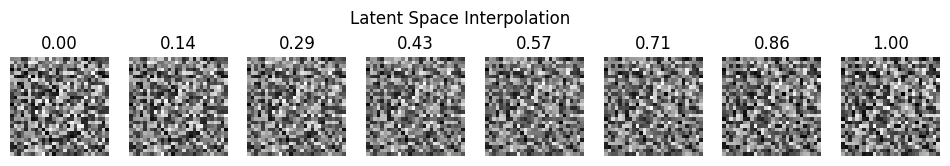

In [9]:
# Latent space interpolation
z1 = rng.normal(0, 1, size=(1, noise_dim))
z2 = rng.normal(0, 1, size=(1, noise_dim))

alphas = np.linspace(0, 1, 8)  # 8 interpolation steps
interpolations = []

for a in alphas:
    z = (1 - a) * z1 + a * z2
    g_h1 = leaky_relu(z @ W1_g + b1_g)
    g_h2 = leaky_relu(g_h1 @ W2_g + b2_g)
    sample = np.tanh(g_h2 @ W3_g + b3_g)
    interpolations.append(sample)

# Plot results
fig, axes = plt.subplots(1, len(alphas), figsize=(12, 2))
for i, ax in enumerate(axes.flat):
    ax.imshow(interpolations[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    ax.set_title(f"{alphas[i]:.2f}")
plt.suptitle("Latent Space Interpolation")
plt.show()
